# Introduction

This notebook uses the Bradley-Terry model to infer the relative strength of Japanese Large Language Models. As input it takes a list of matchups between models. Bradley-Terry is the underlying model behind Elo scores, and the difference is that here we do a maximum a posterior Bayesian analysis to infer the Bradley-Terry strengths rather than the incremental update formula used by Elo. See the [blog post](https://yuzuai.jp/blog/rakuda) for more details.

In [1]:
import json
import math
from datetime import datetime

import emcee
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from IPython.display import Image, Markdown, display
from scipy.optimize import minimize
from utils import load_jsonl

pd.options.display.float_format = "{:.3f}".format
plt.rcParams["text.usetex"] = False

# Loading the data

This notebook is the final step of the jrank pipeline, importing the output of match results produced by matchmaker.py

In [2]:
tournament_file = "./tournaments/rakuda_v1_gpt4.jsonl"
charts_prefix = "./charts/" + tournament_file.split("/")[-1].split(".")[0]

with open(tournament_file, "r") as f:
    tournament = json.load(f)

df = pd.DataFrame(tournament["matches"])
df = df.sample(frac=1)
df = df[["model1_id", "model2_id", "score"]]
df["score"] = df["score"].map({1: 1, 2: 0, 3: 0.5})


df.sample(5)  # score 1 -> model 1 victory, 0 -> model 2 victory, 0.5 -> draw

,model1_id,model2_id,score
505,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,super-torin-sama-alpha2,0.000
741,super-torin-sama-alpha2,cyberagent/open-calm-7b,1.000
54,gpt-4:20230713,rinna/japanese-gpt-neox-3.6b,1.000
567,cyberagent/open-calm-7b,gpt-3.5-turbo-0301:20230614,0.000
13,cyberagent/open-calm-7b,super-torin-sama-alpha2,0.000


In [3]:
from collections import Counter

score_distribution = Counter(df["score"])
print(f"Score distribution: {dict(score_distribution)}")

Score distribution: {1.0: 356, 0.0: 370, 0.5: 74}


In [4]:
models = pd.concat([df["model1_id"], df["model2_id"]]).unique()
models = pd.Series(np.arange(len(models)), index=models)
models

gpt-3.5-turbo-0301:20230614                        0
gpt-4:20230713                                     1
rinna/japanese-gpt-neox-3.6b-instruction-ppo       2
rinna/japanese-gpt-neox-3.6b                       3
rwkv-world-jpn-55                                  4
cyberagent/open-calm-7b                            5
super-torin-sama-alpha2                            6
rinna/japanese-gpt-neox-3.6b-instruction-sft-v2    7
izumi-lab/stormy-7b-10ep                           8
dtype: int64

In [5]:
# Number of models
N = len(models)
# Number of matches
M = len(df)

print(f"{N} models played {M} matches")

9 models played 800 matches


In [6]:
# For display purposes it's helpful to have a short version of the model names
short_names = {}
for name in models.index:
    if "gpt-3.5" in name:
        short_name = "gpt-3.5"
    elif "gpt-4" in name:
        short_name = "gpt-4"
    elif "super-torin" in name:
        short_name = "super-torin"
    elif "open-calm-7b" in name:
        short_name = "open-calm-7b"
    elif "stormy" in name:
        short_name = "stormy-7b"
    elif "rwkv-world" in name:
        short_name = "rwkv-world"
    elif "instruction-ppo" in name:
        short_name = "rinna-3.6b-PPO"
    elif "instruction-sft" in name:
        short_name = "rinna-3.6b-SFT"
    elif "neox-3.6b" in name:
        short_name = "rinna-3.6b"
    else:
        short_name = name
    short_names[name] = short_name

# Win Rates: A direct way to rank the models

If all the models play the same opponents the same number of times, the average win-rate of the models in head-to-head matchups should be a direct measure of their overall performance. 

In [7]:
# total number of times model i in first position beats model j in second position
a_ij = df.groupby(["model1_id", "model2_id"])["score"].sum().unstack(fill_value=0)

# total number of times model i in first position loses model j in second position
df_loss = df.copy()
df_loss["score"] = df_loss["score"].apply(
    lambda x: 1 if x == 0 else (0.5 if x == 0.5 else 0)
)
b_ij = df_loss.groupby(["model1_id", "model2_id"])["score"].sum().unstack(fill_value=0)

# total number of times model i plays model j, regardless of order
all_pairs = pd.concat(
    [
        df[["model1_id", "model2_id"]],
        df[["model2_id", "model1_id"]].rename(
            columns={"model2_id": "model1_id", "model1_id": "model2_id"}
        ),
    ]
)
n_ij = all_pairs.groupby(["model1_id", "model2_id"]).size().unstack(fill_value=0)
assert n_ij.sum().sum() == 2 * M

# win fraction of model i against model j, regardless of order
win_frac_ij = (a_ij + b_ij.T) / n_ij

# overall average win rate
w_i = (a_ij + b_ij.T).sum(axis=1) / ((a_ij + b_ij.T) + (a_ij + b_ij.T).T).sum(axis=1)

win_rates = w_i.sort_values(ascending=True)
win_rates

model1_id
rinna/japanese-gpt-neox-3.6b                      0.166
cyberagent/open-calm-7b                           0.273
rinna/japanese-gpt-neox-3.6b-instruction-sft-v2   0.299
izumi-lab/stormy-7b-10ep                          0.328
rinna/japanese-gpt-neox-3.6b-instruction-ppo      0.387
rwkv-world-jpn-55                                 0.534
super-torin-sama-alpha2                           0.571
gpt-3.5-turbo-0301:20230614                       0.844
gpt-4:20230713                                    0.926
dtype: float64

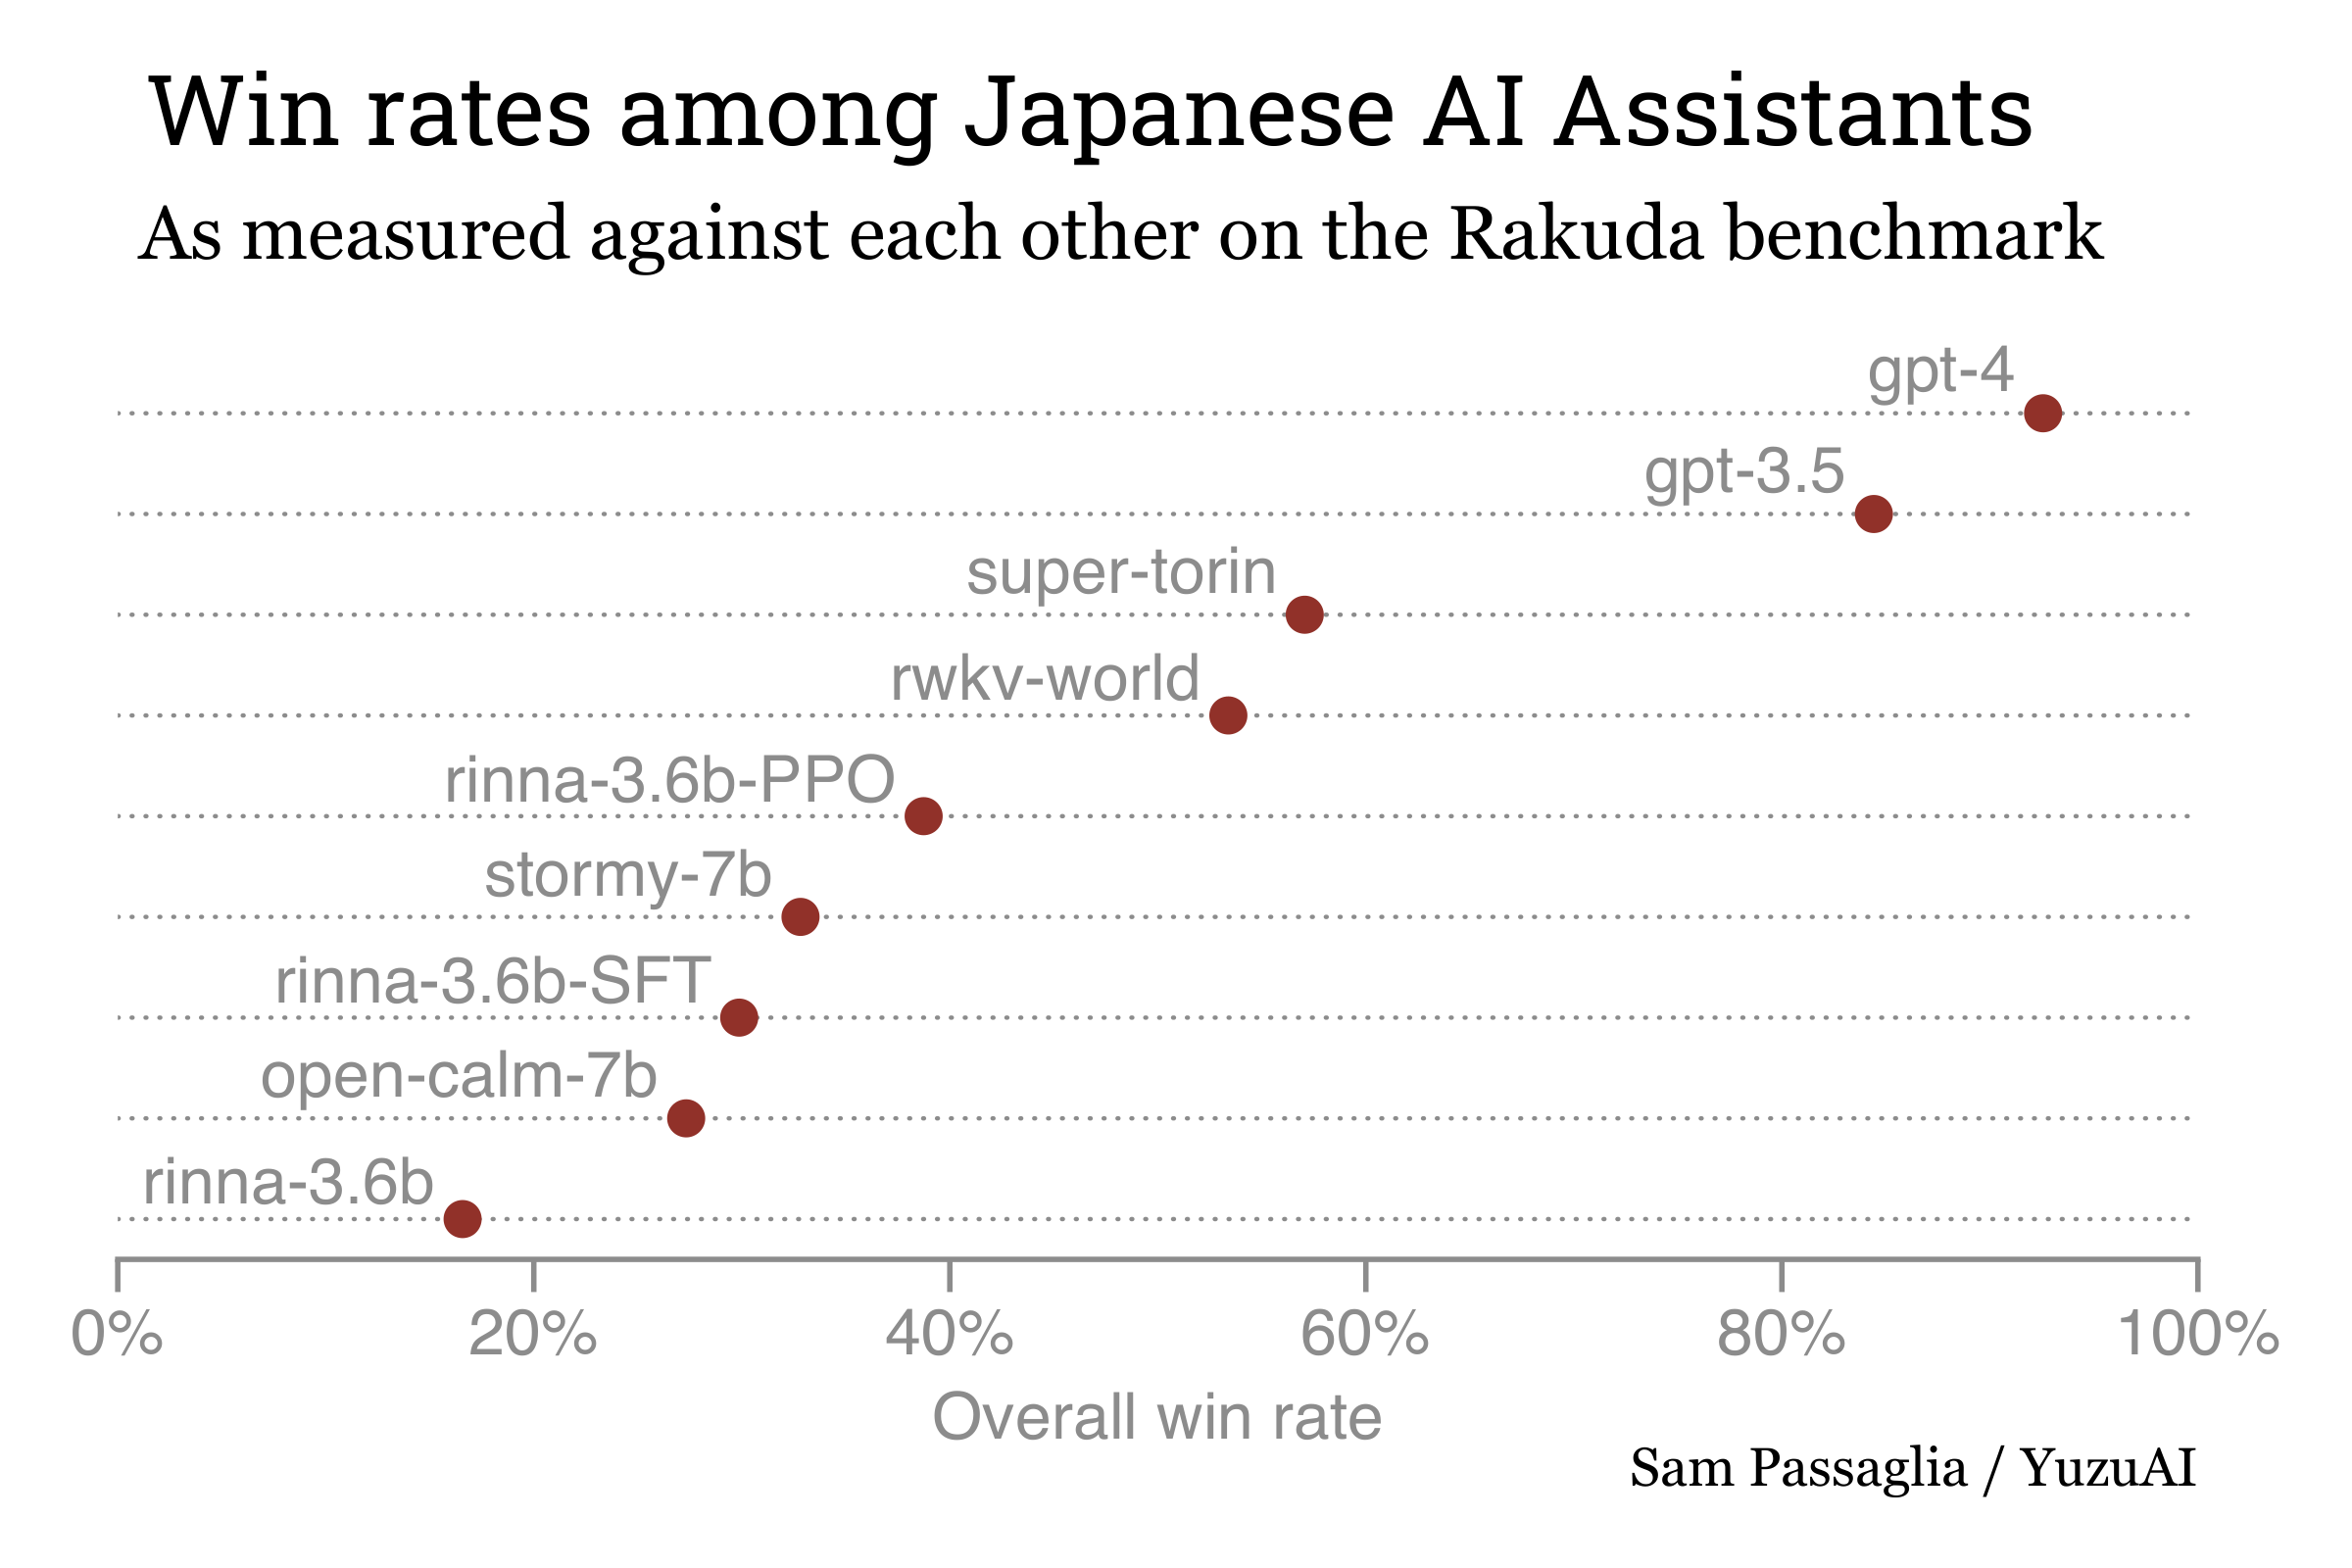

In [8]:
# # Get x values and error values
x_values = win_rates.values
labels = [short_names[model] for model in win_rates.index]
y_values = range(len(x_values))

# Plot
try:
    import samplotlib
    from samplotlib import colors
    from samplotlib.circusboy import CircusBoy

    cb = CircusBoy()
    BGColor = "#FFFFFF"
    plt.rcParams["axes.facecolor"] = BGColor
    plt.rcParams["figure.facecolor"] = BGColor
    plt.rcParams["savefig.facecolor"] = BGColor

    fig, ax = cb.handlers()
    #cb.set_yTickLabels(ax, yoffset=0)

    ax.scatter(x_values * 100, y_values)
    ax.set_xlabel(r"Overall win rate")
    cb.set_byline(ax, "Sam Passaglia / YuzuAI", pad=4)

    cb.set_title(
        ax,
        title="Win rates among Japanese AI Assistants",
        subtitle="As measured against each other on the Rakuda benchmark",
    )
    ax.set_xlim([0, 100])

    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

    ax.set_yticks(y_values, [])
    
    for i, txt in enumerate(labels):
        ax.annotate(txt, xy=(x_values[i] * 100, y_values[i]), xytext=(-5, 7), ha='right', va='center', textcoords='offset points', color=cb.grey)

    fig.savefig(charts_prefix + "winrate.png")
    fig.savefig(charts_prefix + "winrate.pdf")
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams["text.usetex"] = True
except ImportError:
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values)
    plt.xlabel("Overall win rate")
    plt.yticks(y_values, labels)
    plt.savefig(charts_prefix + "winrate.png")
    plt.show()
    
Image(charts_prefix + "winrate.png", width=800)

# Bradley-Terry: A more flexible way to rank

We might not always be in the situation where all models face the same set of opponents the same number of times.
In that case we want a more robust mathematical model for our data. We choose to use the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model).

We model the probability that model $i$ in the first position beats model $j$ in the second position as 

$p_{ij} = \dfrac{e^{\alpha+\beta_i - \beta_j}}{1+e^{\alpha+\beta_i-\beta_j}}$

where $\beta_i$ is the strength of model $i$ and $\alpha$ is a home field advantage parameter that is greater than 0 if the model in the first position is favored over the model in the second position and is less than 0 if the second model is favored. Draws are counted as a half-win for each teams.

We can scale the ratings as we wish, as an aesthetic choice which has no mathematical effect. The following parameters set the ratings to correspond to the traditional ELO scores.

In [9]:
SCALE = 400
BASE = 10
INIT_RATING = 1000

# Maximum Likelihood Estimation

To find the best-fit model strengths, we maximize the likelihood of the data given the parameters using scipy

In [10]:
def compute_elo_mle(df, SCALE=1, BASE=np.e, INIT_RATING=0, fit_home_advantage=True):

    models = pd.concat([df["model1_id"], df["model2_id"]]).unique()
    models = pd.Series(np.arange(len(models)), index=models)

    # Score vector
    Y_m = df[
        "score"
    ].values  # 1 if i_m beat j_m in the mth game, .5 for a draw, 0 otherwise

    # match vectors: who played in the mth match
    i_m = df.apply(lambda row: models[row["model1_id"]], axis=1).values
    j_m = df.apply(lambda row: models[row["model2_id"]], axis=1).values

    # log likelihood of the data given the parameters
    # see, e.g., https://web.stanford.edu/class/archive/stats/stats200/stats200.1172/Lecture24.pdf
    def l(alpha, betas, Y_m, i_m, j_m):
        alpha_plus_betas_diff = alpha + betas[i_m] - betas[j_m]
        return np.sum(
            Y_m * alpha_plus_betas_diff - np.log1p(np.exp(alpha_plus_betas_diff))
        )

    # Initial guess for the parameters
    x0 = np.zeros(len(models) + 1)

    # Define the system of equations
    def F(x):
        if not fit_home_advantage:
            x[0] = 0
        x[1] = -np.sum(x[2:])  # enforces sum of scores is ~0
        return -l(x[0], x[1:], Y_m, i_m, j_m)

    # Minimize the negative likelihood
    max_likelihood = minimize(F, x0, method="L-BFGS-B")

    # Impose the sum of scores is ~0
    max_likelihood.x[1] = -np.sum(max_likelihood.x[2:])

    # Scale the scores
    scaled_MLE_scores = (
        SCALE
        / math.log(BASE)
        * pd.Series(max_likelihood.x[1:], index=models.index).sort_values(
            ascending=False
        )
        + INIT_RATING
    )
    scaled_MLE_advantage = SCALE / math.log(BASE) * max_likelihood.x[0]

    if not fit_home_advantage:
        return scaled_MLE_scores
    else:
        return (
            scaled_MLE_scores,
            scaled_MLE_advantage,
        )

In [11]:
scaled_MLE_scores, scaled_MLE_advantage = compute_elo_mle(
    df, SCALE=SCALE, BASE=BASE, INIT_RATING=INIT_RATING
)

In [12]:
print(scaled_MLE_scores)

gpt-4:20230713                                    1511.241
gpt-3.5-turbo-0301:20230614                       1378.629
rwkv-world-jpn-55                                 1075.453
super-torin-sama-alpha2                           1010.806
rinna/japanese-gpt-neox-3.6b-instruction-ppo       862.586
izumi-lab/stormy-7b-10ep                           848.217
rinna/japanese-gpt-neox-3.6b-instruction-sft-v2    814.523
cyberagent/open-calm-7b                            794.771
rinna/japanese-gpt-neox-3.6b                       703.776
dtype: float64


# Check that the MLE has converged as a function of num_matches

In [13]:
nstep = 10
steps = np.arange(100, len(df) + nstep, nstep)

In [14]:
for step in steps:
    current_scores, advantage = compute_elo_mle(
        df.iloc[:step], SCALE=SCALE, BASE=BASE, INIT_RATING=INIT_RATING
    )
    current_scores = current_scores.rename(step)
    if step == steps[0]:
        score_history = current_scores
    else:
        score_history = pd.concat([score_history, current_scores], axis=1)

/var/folders/11/j3g79k457_3bn3y771_l47fr0000gn/T/ipykernel_6611/237867415.py:14: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


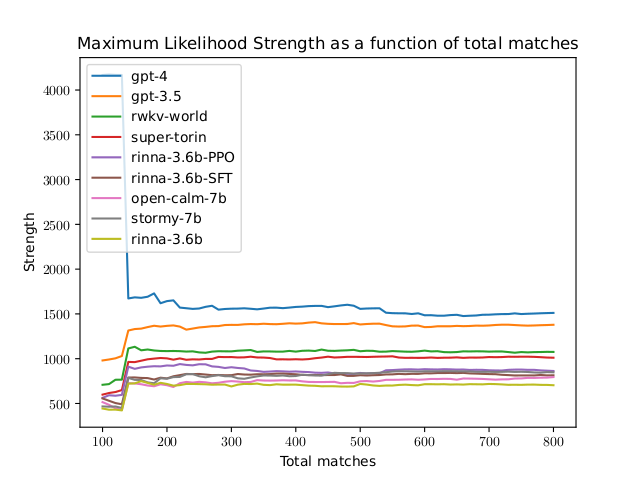

In [15]:
# Plotting the elo_history

fig, ax = plt.subplots()

for model in score_history.index:
    ax.plot(steps, score_history.loc[model], label=short_names[model])

ax.set_xlabel("Total matches")
ax.set_ylabel("Strength")
ax.set_title("Maximum Likelihood Strength as a function of total matches")
ax.legend(loc="upper left")

plt.savefig(charts_prefix + "evolution.png")
plt.show()
    
Image(charts_prefix + "evolution.png", width=800)


# Bayesian confidence regions using MCMC

See the [emcee tutorial](https://emcee.readthedocs.io/en/stable/tutorials/line/) for a crash-course of Bayesian fitting, or [this nice paper](https://arxiv.org/pdf/1008.4686.pdf) for a more complete but still pedagogical look.


In [16]:
# Parameter space dimension
ndim = N + 1

# Score vector
Y_m = df[
    "score"
].values  # 1 if i_m beat j_m in the mth game, .5 for a draw, 0 otherwise

# match vectors: who played in the mth match
i_m = df.apply(lambda row: models[row["model1_id"]], axis=1).values
j_m = df.apply(lambda row: models[row["model2_id"]], axis=1).values

# likelihood
def l(alpha, betas, Y_m, i_m, j_m):
    alpha_plus_betas_diff = alpha + betas[i_m] - betas[j_m]
    return np.sum(Y_m * alpha_plus_betas_diff - np.log1p(np.exp(alpha_plus_betas_diff)))


# Prior: What we knew before running the experiment
# We choose flat priors that don't constrain the parameters much
def log_prior(x):
    if -1 < x[0] < 1 and all([-4 < beta < 4 for beta in x[1:]]):
        return 0.0
    return -np.inf


# Log Probability = Log_Prior + Log Likelihood
def log_probability(x):
    x[1] = -np.sum(x[2:])  # enforces sum of scores is 0
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + l(x[0], x[1:], Y_m, i_m, j_m)

In [76]:
# Parameters of the MCMC
# This will launch an MCMC that takes about ~ 4 minute to run on a M1 mac cpu
# If too slow just reduce nsamples or nwalkers, default numbers are overkill for computing confidence intervals
from multiprocess import Pool

# Maximum number of samples per chain
nsamples = 20000

# Number of independent chains
nwalkers = 40

# Initialize the walkers randomly around the MLE point
MLE_scores, MLE_advantage = compute_elo_mle(df)
p0 = np.random.normal(
    np.concatenate([[MLE_advantage], MLE_scores[models.index].values]),
    0.01,
    (nwalkers, ndim),
)

# Set up the location to save the mcmc
# Don't forget to clear it in case the file already exists
filename = "mcmc.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(nsamples)

# This will be useful to testing convergence
old_tau = np.inf

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, backend=backend, pool=pool
    )
    # We sample for up to nsamples steps
    for sample in sampler.sample(p0, iterations=nsamples, progress=True):
        # Only check convergence every 1000 steps
        if sampler.iteration % 1000:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # We'll consider things converged if the chain is longer than 50 times the autocorrelation time
        # and this estimate has changed by less than 5 percent since the last check.
        converged = np.all(tau * 50 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.05)
        if converged:
            break
        old_tau = tau

# To reload chains follow these instructions: https://emcee.readthedocs.io/en/stable/tutorials/monitor/

 55%|█████████████████████████████▏                       | 11000/20000 [02:35<02:07, 70.77it/s]


In [96]:
# Should be 0.3~0.5
print("Mean acceptance fraction: {0:.2f}".format(np.mean(sampler.acceptance_fraction)))

# Useful for chain burning and thinning
print(
    "Mean autocorrelation time: {0:.0f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.42
Mean autocorrelation time: 103 steps


In [97]:
sampler.get_autocorr_time()

array([111.70972475,  46.55387736, 106.0347929 , 104.8813201 ,
       115.77118205, 109.38394067, 114.39095483, 117.89697111,
       103.71414033,  97.74696323])

In [98]:
# Burn the few * autocorrelation time steps per chain to erase initial conditions
flat_samples = sampler.get_chain(discard=1000, flat=True)
flat_samples[:, 1] = -np.sum(
    flat_samples[:, 2:], axis=1
)  # impose the sum of strengths = 0 constraint that was imposed in the likelihood
print(flat_samples.shape)

(400000, 10)


In [99]:
# Convert chain to desired scaling

scaled_samples = np.copy(flat_samples)

scaled_samples[:, 0] = scaled_samples[:, 0] * SCALE / math.log(BASE)
scaled_samples[:, 1:] = scaled_samples[:, 1:] * SCALE / math.log(BASE) + INIT_RATING

In [100]:
# Compute the confidence interval for all the parameters
error_interval = [16, 50, 84]

mcmc = np.percentile(scaled_samples[:, 0], error_interval)
q = np.diff(mcmc)
advantage_quantiles = {
    "median": mcmc[1],
    "one_sigma_up": q[1],
    "one_sigma_down": q[0],
}
print('advantage parameter', advantage_quantiles)

strengths = pd.DataFrame(
    columns=["model_id", "median", "one_sigma_up", "one_sigma_down"]
)

for i in range(ndim - 1):
    mcmc = np.percentile(scaled_samples[:, i + 1], error_interval)
    q = np.diff(mcmc)

    strengths = pd.concat(
        [
            strengths,
            pd.DataFrame(
                [
                    {
                        "model_id": list(models.index)[i],
                        "median": mcmc[1],
                        "one_sigma_up": q[1],
                        "one_sigma_down": q[0],
                    }
                ]
            ),
        ],
        ignore_index=True,
    )

strengths = strengths.sort_values("median", ascending=False).reset_index(drop=True)
strengths

advantage parameter {'median': -28.332433529462442, 'one_sigma_up': 18.39859555623478, 'one_sigma_down': 17.963724621470156}


,model_id,median,one_sigma_up,one_sigma_down
0,gpt-4:20230713,1520.435,53.188,49.035
1,gpt-3.5-turbo-0301:20230614,1384.010,45.627,42.466
2,rwkv-world-jpn-55,1076.665,34.254,33.808
3,super-torin-sama-alpha2,1010.506,32.128,31.249
4,rinna/japanese-gpt-neox-3.6b-instruction-ppo,860.023,33.302,33.941
5,izumi-lab/stormy-7b-10ep,845.533,32.248,33.312
6,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,810.900,33.782,33.448
7,cyberagent/open-calm-7b,790.513,32.769,33.448
8,rinna/japanese-gpt-neox-3.6b,698.991,35.753,37.167


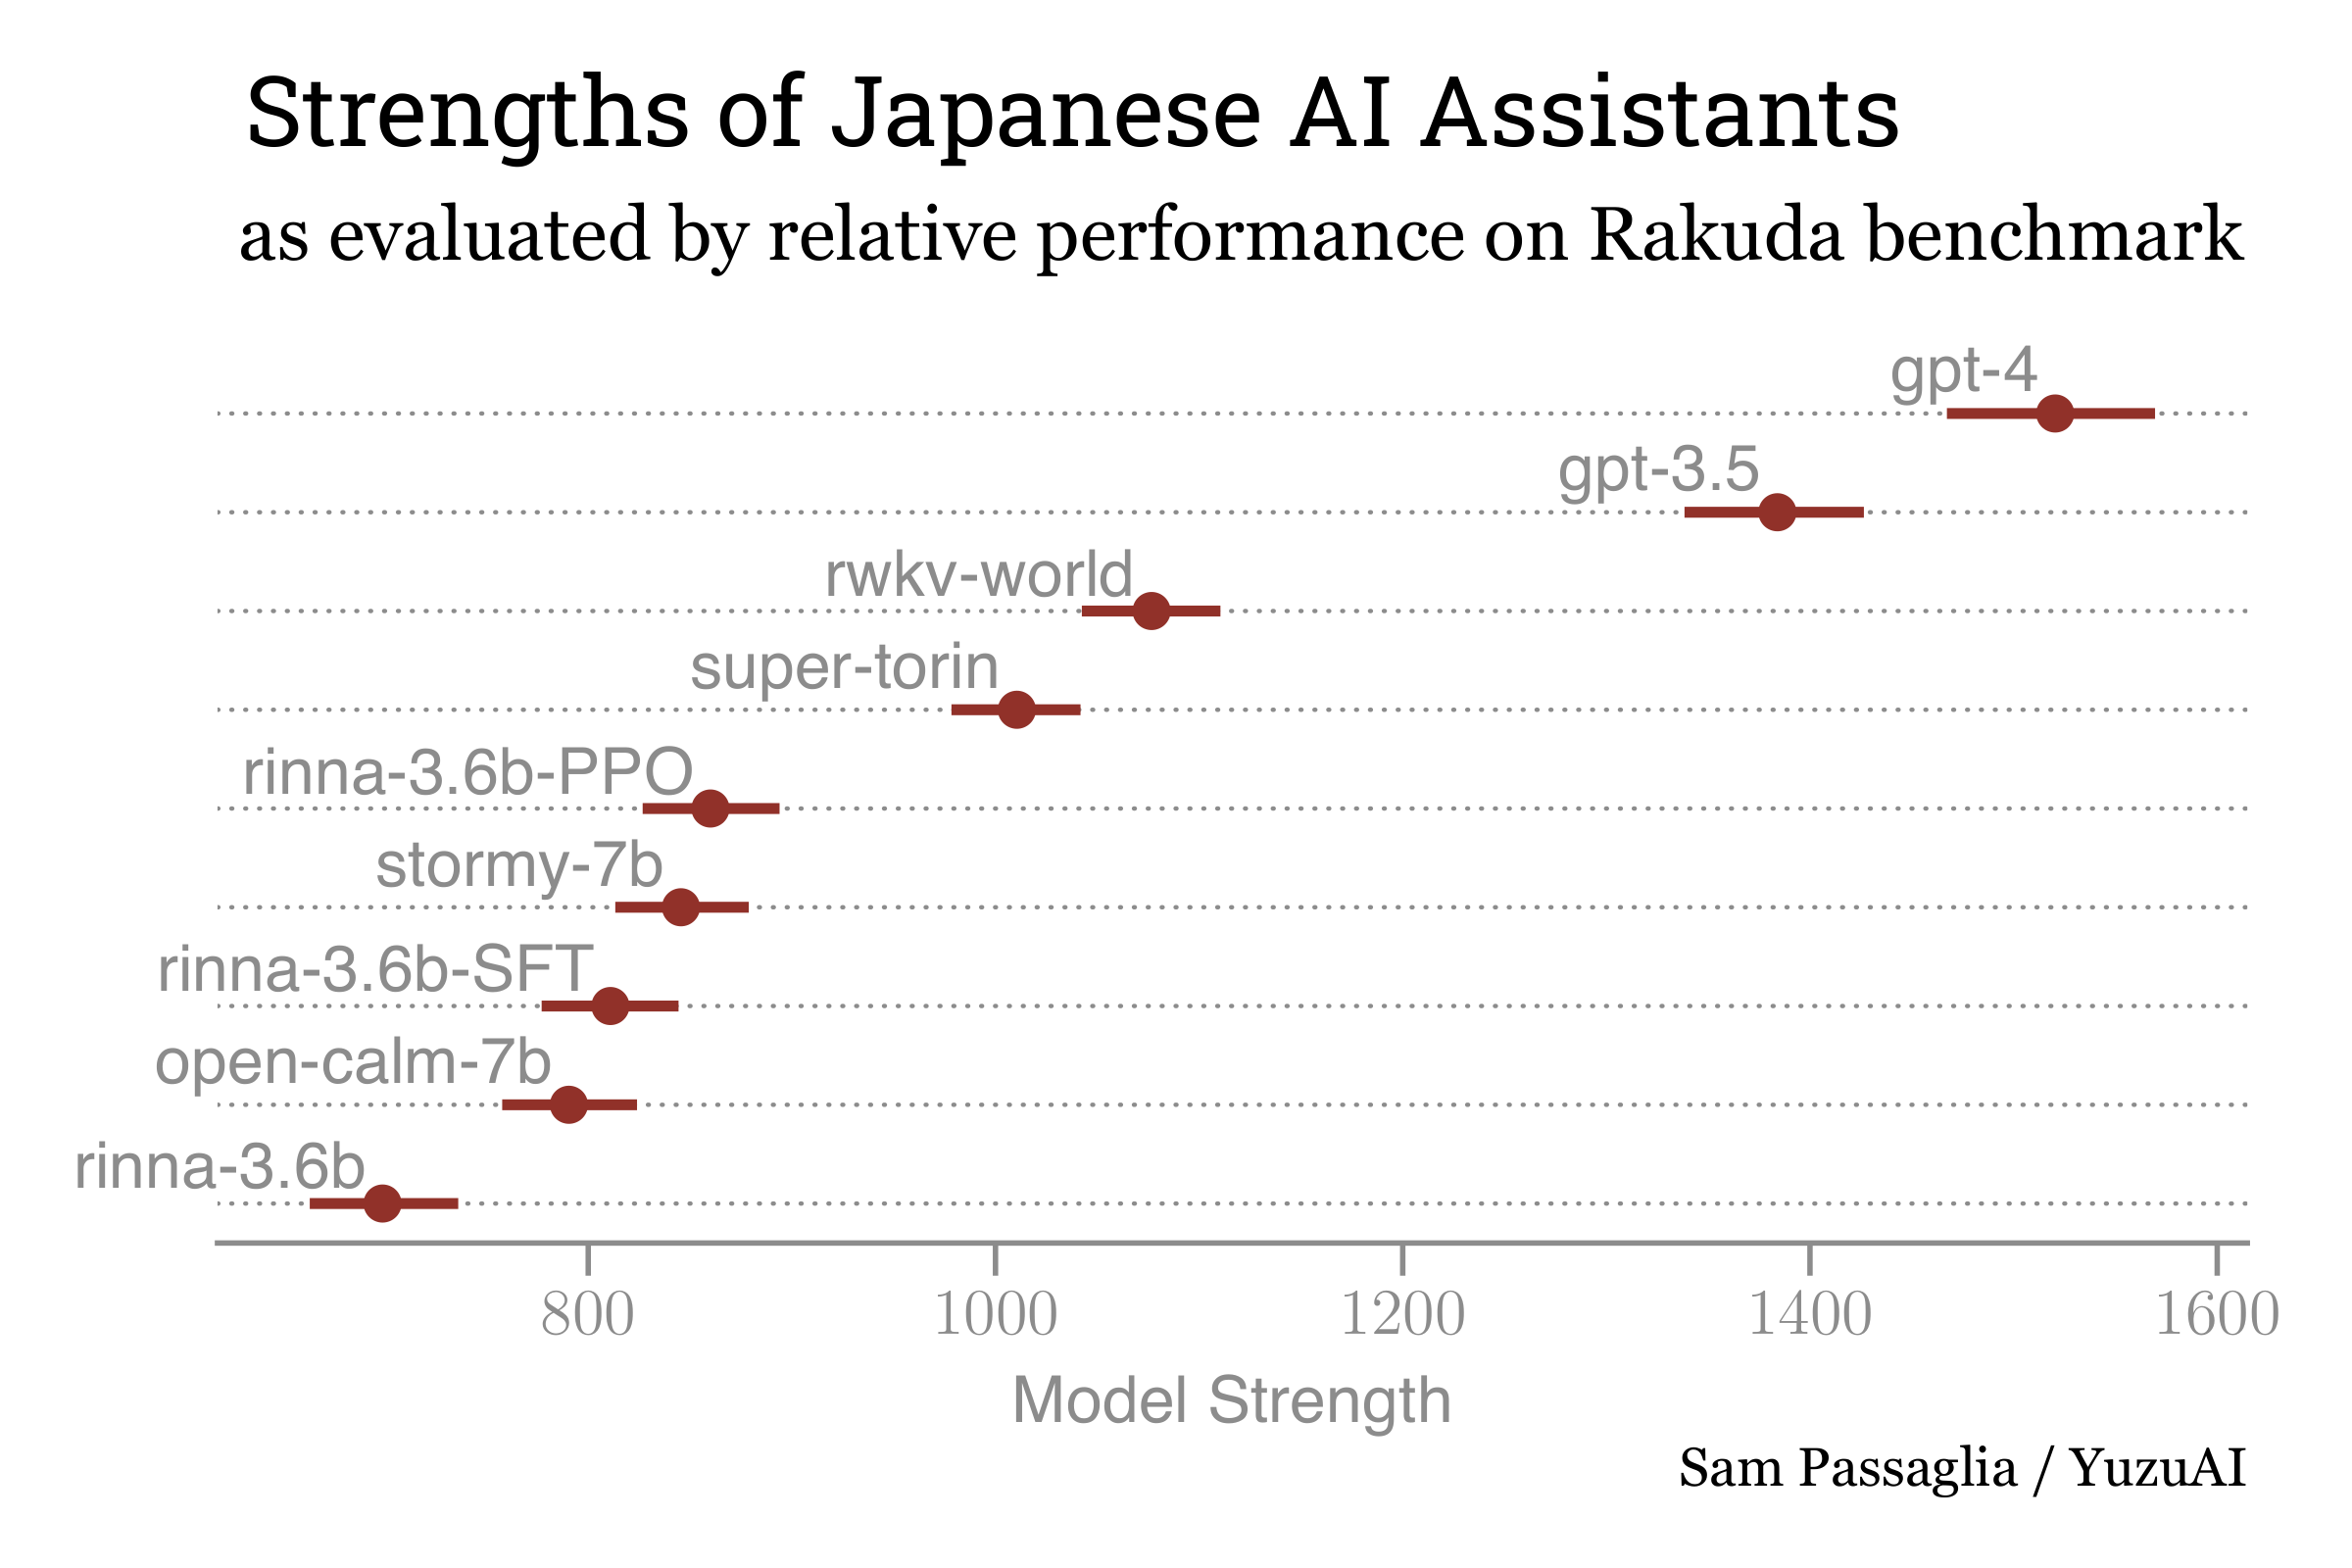

In [101]:
# Plot all the strengths

x_values = strengths["median"]
y_values = strengths["median"].argsort().values
errors = [strengths["one_sigma_up"], strengths["one_sigma_down"]]
labels = strengths["model_id"].apply(lambda x: short_names[x])

try:
    from samplotlib import colors
    from samplotlib.circusboy import CircusBoy

    cb = CircusBoy()
    BGColor = "#FFFFFF"
    plt.rcParams["axes.facecolor"] = BGColor
    plt.rcParams["figure.facecolor"] = BGColor
    plt.rcParams["savefig.facecolor"] = BGColor

    fig, ax = cb.handlers()
    
    ax.errorbar(x_values, y_values, xerr=errors, fmt="o")
    ax.set_xlabel(r"Model Strength")
    cb.set_byline(ax, "Sam Passaglia / YuzuAI", pad=7)

    cb.set_title(
        ax,
        title="Strengths of Japanese AI Assistants",
        subtitle="as evaluated by relative performance on Rakuda benchmark",
    )

    ax.set_yticks(y_values, [])
    
    for i, txt in enumerate(labels):
        ax.annotate(txt, xy=(x_values[i], y_values[i]), xytext=(-3, 7), ha='right', va='center', textcoords='offset points', color=cb.grey)

    fig.savefig(charts_prefix + "ranking.png")
    fig.savefig(charts_prefix + "ranking.pdf")
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams["text.usetex"] = True

except ImportError:
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        x_values,
        y_values,
        xerr=errors,
        fmt="o",
    )
    plt.xlabel("Model Strength")
    plt.yticks(y_values, labels)
    plt.savefig(charts_prefix + "ranking.png")
    # plt.show()

Image(charts_prefix + "ranking.png", width=800)

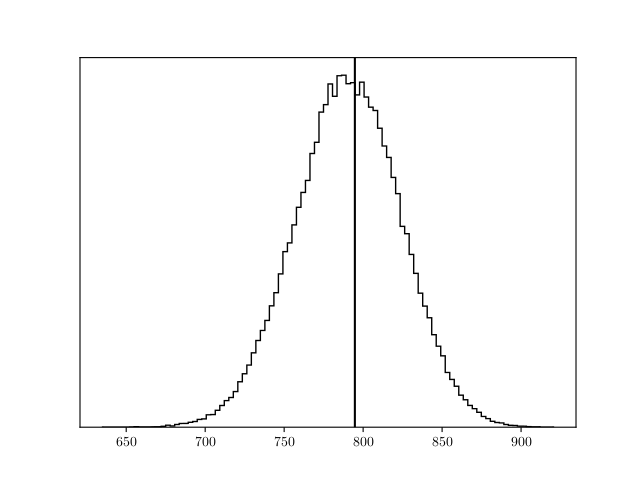

In [102]:
# Plot a parameter distribution
# Note we don't expect maximum likelihood point to necessarily agree with maximum of the marginalized 1D posterior distribution
# See page 16 of https://arxiv.org/pdf/1008.4686.pdf

model = "cyberagent/open-calm-7b"

scaled_MLE_scores, scaled_MLE_advantage = compute_elo_mle(
    df, SCALE=SCALE, BASE=BASE, INIT_RATING=INIT_RATING
)
plt.close("all")
plt.hist(
    scaled_samples[:, models[model] + 1],
    100,
    color="k",
    histtype="step",
    label="Posterior Samples",
)
plt.axvline(scaled_MLE_scores[model], color="k", label="MLE")

# plt.xlabel(parameter_labels_with_dollar[parameter_index])
# plt.ylabel(rf"$p({parameter_labels[parameter_index]})$")
plt.gca().set_yticks([])
plt.savefig(charts_prefix + "parameter.png")
plt.legend()

# If using a non-interactive matplotlib back-end
Image(charts_prefix + "parameter.png", width=800)

rwkv-world is stronger than super-torin with 91.38% confidence


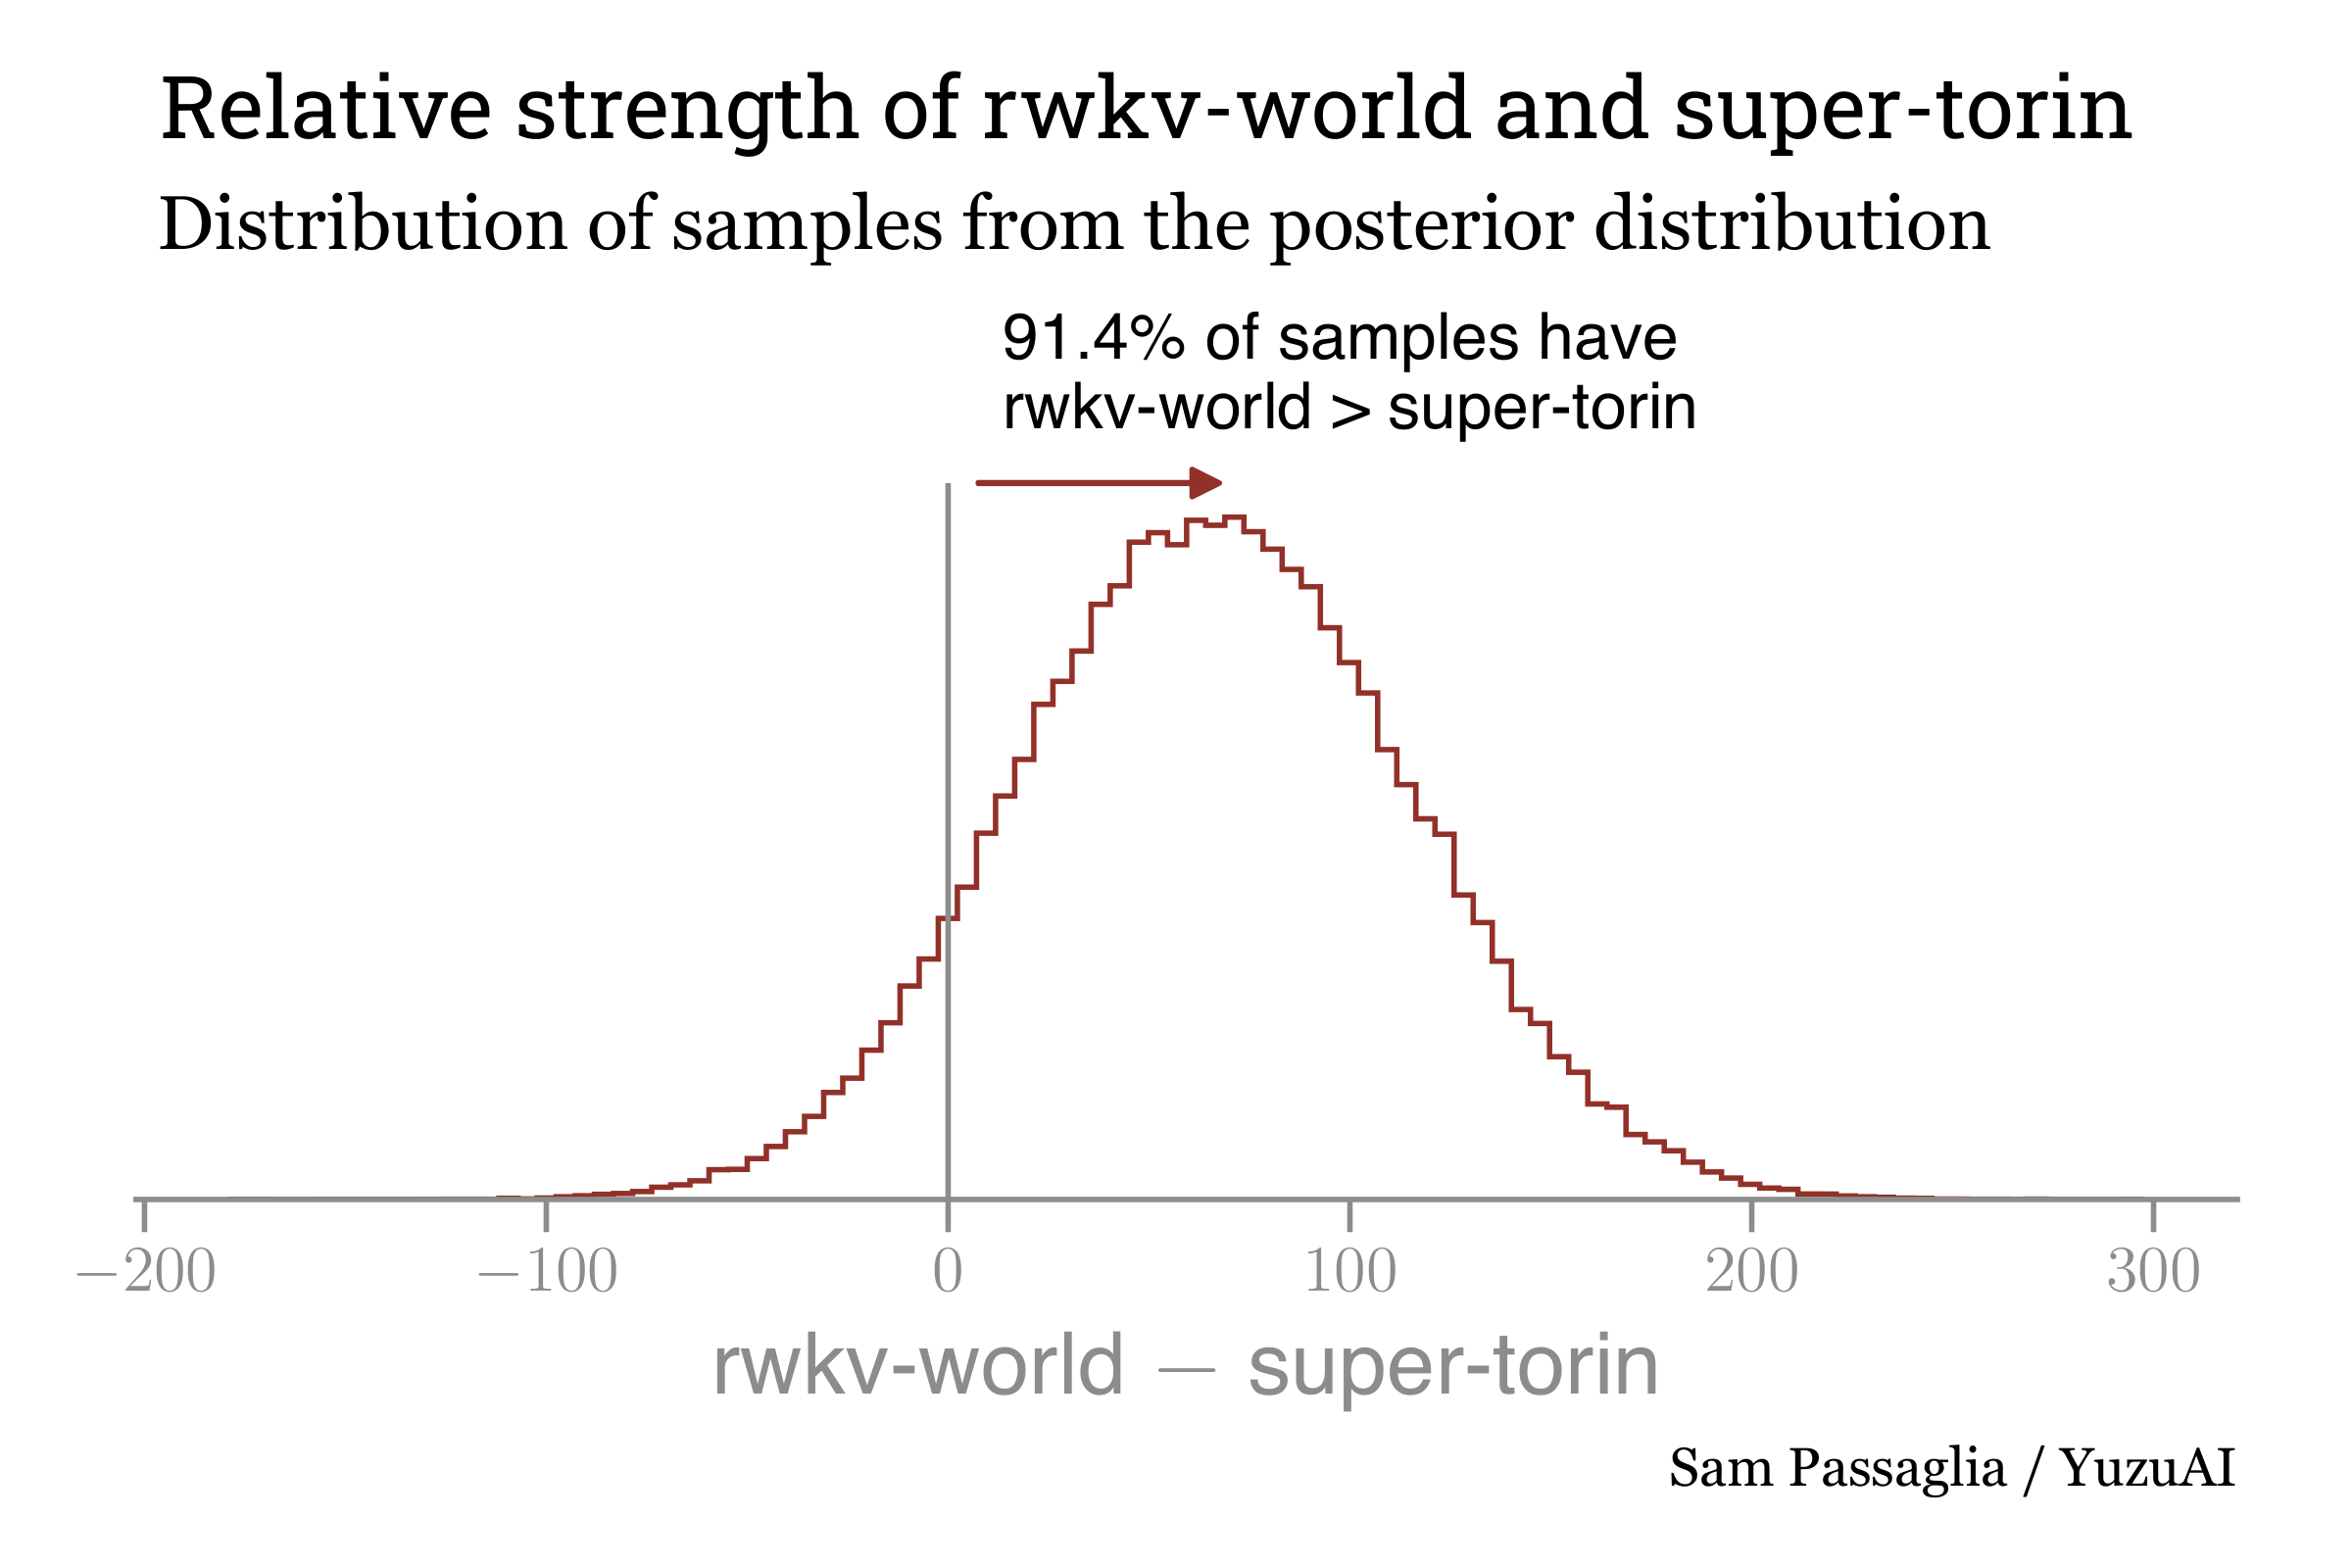

In [103]:
# Compute relative strength probabilities
modelA = "rwkv-world-jpn-55"
modelB = "super-torin-sama-alpha2"

diffs = scaled_samples[:, models[modelA] + 1] - scaled_samples[:, models[modelB] + 1]


A_stronger_rate = np.sum(
    scaled_samples[:, models[modelA] + 1] > scaled_samples[:, models[modelB] + 1]
) / len(scaled_samples)
print(
    f"{short_names[modelA]} is stronger than {short_names[modelB]} with {A_stronger_rate:.2%} confidence"
)


# Plot
try:
    from samplotlib import colors
    from samplotlib.circusboy import CircusBoy

    cb = CircusBoy()
    BGColor = "#FFFFFF"
    plt.rcParams["axes.facecolor"] = BGColor
    plt.rcParams["figure.facecolor"] = BGColor
    plt.rcParams["savefig.facecolor"] = BGColor

    fig, ax = cb.handlers()

    hist = ax.hist(diffs, 100, histtype="step")
    ax.set_xlabel(
        rf"{short_names[modelA]} $-$ {short_names[modelB]}$",
        size=16,
    )
    arrow_height = 1.0
    ax.annotate(
        "",
        xytext=(0, arrow_height),
        xy=(75, arrow_height),
        xycoords=("data", "axes fraction"),
        arrowprops=dict(
            facecolor=hist[2][0]._facecolor[:3],
            edgecolor=hist[2][0]._facecolor[:3],
            width=0.15,
            headlength=5,
            headwidth=5,
            shrink=0.1,
        ),
    )

    ax.annotate(
        f"{A_stronger_rate:.1%} of samples have \n {short_names[modelA]} > {short_names[modelB]}",
        xy=(0.0, arrow_height),
        xycoords=("data", "axes fraction"),
        xytext=(10, 10),
        textcoords="offset points",
    )
    plt.gca().set_yticks([])
    cb.set_byline(ax, "Sam Passaglia / YuzuAI", pad=15)
    ax.axvline(0, color=cb.grey, lw=1)
    cb.set_title(
        ax,
        title=f"Relative strength of {short_names[modelA]} and {short_names[modelB]}",
        subtitle=f"Distribution of samples from the posterior distribution",
        titlesize=16,
        subtitlesize=14,
        pad=40,
    )

    fig.savefig(charts_prefix + "diff.png")
    fig.savefig(charts_prefix + "diff.pdf")
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams["text.usetex"] = True

except ImportError:

    plt.close("all")
    plt.figure(figsize=(10, 6))
    plt.hist(
        diffs,
        100,
        color="k",
        histtype="step",
    )
    plt.axvline(0, ls="--", color="k")
    plt.xlabel(f"{modelA} elo - {modelB} elo")

    plt.gca().set_yticks([])
    plt.savefig(charts_prefix + "diff.png")
    # plt.show()

Image(charts_prefix + "diff.png", width=800)

In [104]:
# Compute this for all models
strengths["stronger_than_next_confidence"] = -1

for i in range(len(strengths) - 1):

    modelA = strengths.iloc[i]["model_id"]
    modelB = strengths.iloc[i + 1]["model_id"]

    A_stronger_rate = np.sum(
        scaled_samples[:, models[modelA] + 1] > scaled_samples[:, models[modelB] + 1]
    ) / len(flat_samples)
    print(
        f"{short_names[modelA]} is stronger than {short_names[modelB]} with {A_stronger_rate:.2%} confidence"
    )
    strengths.loc[
        strengths["model_id"] == modelA, "stronger_than_next_confidence"
    ] = A_stronger_rate

gpt-4 is stronger than gpt-3.5 with 99.35% confidence
gpt-3.5 is stronger than rwkv-world with 100.00% confidence
rwkv-world is stronger than super-torin with 91.38% confidence
super-torin is stronger than rinna-3.6b-PPO with 99.97% confidence
rinna-3.6b-PPO is stronger than stormy-7b with 62.02% confidence
stormy-7b is stronger than rinna-3.6b-SFT with 76.28% confidence
rinna-3.6b-SFT is stronger than open-calm-7b with 67.01% confidence
open-calm-7b is stronger than rinna-3.6b with 97.22% confidence


In [105]:
# Also add win rates, for reference
strengths["win_rate"] = strengths.apply(lambda row: win_rates[row["model_id"]], axis=1)

Removed no burn in


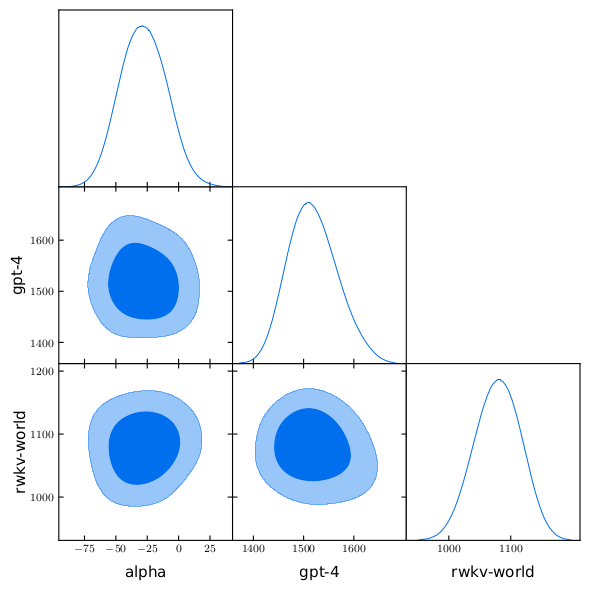

In [106]:
# Finally we can make a triangle plot just to show off
import getdist
from getdist import MCSamples, plots

samples = MCSamples(
    samples=scaled_samples[::200],
    names=["alpha"] + [short_names[model] for model in list(models.index)],
)  # names = names, labels = labels)

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples], ["alpha", "gpt-4", "rwkv-world"], filled=True)
g.export(charts_prefix + "corner_getdist.png")
Image(charts_prefix + "corner_getdist.png", width=800)

# Output standings and make table

In [117]:
strengths["short_name"] = strengths["model_id"].apply(lambda x: short_names[x])
strengths = strengths.sort_values('median')

In [119]:
output = {
    "date": datetime.now().isoformat(),
    "model_metadata": tournament["model_metadata"],
    "metadata": tournament["metadata"],
    "ranking": strengths.to_dict(orient="records"),
}

In [120]:
output_path = f"./rankings/{tournament_file.split('/')[-1].split('.')[0]}.json"

In [121]:
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

In [122]:
from registry import StandingsRegistry

registry = StandingsRegistry("./registry/registry.jsonl")
registry.register(output_path)

In [126]:
import json
import os
from datetime import datetime


def model_hyperlink(link, model_name):
    return f'<a target="_blank" href="{link}" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">{model_name}</a>'


def make_clickable_model(model_name):
    link = f"https://huggingface.co/{model_name}"

    # Can hardcode urls and names here
    if "gpt-3.5-turbo" in model_name:
        link = "https://openai.com/"
        model_name = "openai/GPT-3.5"
    elif "gpt-4" in model_name:
        link = "https://openai.com/"
        model_name = "openai/GPT-4"
    elif "super-torin" in model_name:
        link = "https://ai-novel.com/index.php"
        model_name = "ainovelist/super-torin"
    elif "rwkv" in model_name:
        link = "https://huggingface.co/BlinkDL/rwkv-4-world"
        model_name = "blinkdl/rwkv-4-world-jp55"
        
    return model_hyperlink(link, model_name)


rankings = sorted(output["ranking"], key=lambda x: x["median"], reverse=True)
table = "| Rank | Model | Strength | Stronger than the next model at confidence level  | \n| :--- | :---: | :---: | :---: |\n"
for i, rank in enumerate(rankings):
    # assert(round(rank['one_sigma_up'],2) == round(rank['one_sigma_down'],2))
    table += f"| {i+1} | {make_clickable_model(rank['model_id'])} | {rank['median']:.3f} ± {rank['one_sigma_up']:.2f}  | { str(round(rank['stronger_than_next_confidence']*100,1))+'%' if rank['stronger_than_next_confidence']!=0 else 'N/A'}\n"

In [127]:
print(table)
display(Markdown(table))

| Rank | Model | Strength | Stronger than the next model at confidence level  | 
| :--- | :---: | :---: | :---: |
| 1 | <a target="_blank" href="https://openai.com/" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">openai/GPT-4</a> | 1520.435 ± 53.19  | 99.4%
| 2 | <a target="_blank" href="https://openai.com/" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">openai/GPT-3.5</a> | 1384.010 ± 45.63  | 100.0%
| 3 | <a target="_blank" href="https://huggingface.co/BlinkDL/rwkv-4-world" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">blinkdl/rwkv-4-world-jp55</a> | 1076.665 ± 34.25  | 91.4%
| 4 | <a target="_blank" href="https://ai-novel.com/index.php" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">ainovelist/super-torin</a> | 1010.506 ± 32.13  | 100.0%
| 5 | <a target="_blank" href="https://huggingface.co/rinna/japanese-gpt-neox-3.6b-instruction-ppo" style="color:#1e50a2, textDe

| Rank | Model | Strength | Stronger than the next model at confidence level  | 
| :--- | :---: | :---: | :---: |
| 1 | <a target="_blank" href="https://openai.com/" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">openai/GPT-4</a> | 1520.435 ± 53.19  | 99.4%
| 2 | <a target="_blank" href="https://openai.com/" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">openai/GPT-3.5</a> | 1384.010 ± 45.63  | 100.0%
| 3 | <a target="_blank" href="https://huggingface.co/BlinkDL/rwkv-4-world" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">blinkdl/rwkv-4-world-jp55</a> | 1076.665 ± 34.25  | 91.4%
| 4 | <a target="_blank" href="https://ai-novel.com/index.php" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">ainovelist/super-torin</a> | 1010.506 ± 32.13  | 100.0%
| 5 | <a target="_blank" href="https://huggingface.co/rinna/japanese-gpt-neox-3.6b-instruction-ppo" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">rinna/japanese-gpt-neox-3.6b-instruction-ppo</a> | 860.023 ± 33.30  | 62.0%
| 6 | <a target="_blank" href="https://huggingface.co/izumi-lab/stormy-7b-10ep" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">izumi-lab/stormy-7b-10ep</a> | 845.533 ± 32.25  | 76.3%
| 7 | <a target="_blank" href="https://huggingface.co/rinna/japanese-gpt-neox-3.6b-instruction-sft-v2" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">rinna/japanese-gpt-neox-3.6b-instruction-sft-v2</a> | 810.900 ± 33.78  | 67.0%
| 8 | <a target="_blank" href="https://huggingface.co/cyberagent/open-calm-7b" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">cyberagent/open-calm-7b</a> | 790.513 ± 32.77  | 97.2%
| 9 | <a target="_blank" href="https://huggingface.co/rinna/japanese-gpt-neox-3.6b" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">rinna/japanese-gpt-neox-3.6b</a> | 698.991 ± 35.75  | -100.0%
